# Imports


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from visualize import visualize

# Reading Data


In [2]:
df = pd.read_excel(f"../data/raw/Powerol_Data_ML_v3.xlsx")

In [3]:
df.head()

,KVA,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,OEMName,StateName,Region,DealerId,DealerName
0,5.0,1,NaN,0,2023-01-14 11:59:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN
1,5.0,1,NaN,0,2019-02-11 12:20:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2,5.0,1,NaN,0,2020-10-22 08:19:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN
3,5.0,1,NaN,0,2024-01-22 16:08:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN
4,5.0,1,NaN,0,2020-12-17 13:55:00,NaT,NaT,NaN,NaN,NaN,NaN,NaN


---


# Data Understanding


In [4]:
df.shape

(433906, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433906 entries, 0 to 433905
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   KVA             433673 non-null  float64       
 1   Enquiry         433906 non-null  int64         
 2   Book            112397 non-null  float64       
 3   SaleInvoice     433906 non-null  int64         
 4   enquiryDate     433906 non-null  datetime64[ns]
 5   SalesOrderDate  112397 non-null  datetime64[ns]
 6   InvoiceDate     86455 non-null   datetime64[ns]
 7   OEMName         18 non-null      object        
 8   StateName       106177 non-null  object        
 9   Region          106177 non-null  object        
 10  DealerId        130501 non-null  float64       
 11  DealerName      130501 non-null  object        
dtypes: datetime64[ns](3), float64(3), int64(2), object(4)
memory usage: 39.7+ MB


In [6]:
df.isnull().sum()

KVA                  233
Enquiry                0
Book              321509
SaleInvoice            0
enquiryDate            0
SalesOrderDate    321509
InvoiceDate       347451
OEMName           433888
StateName         327729
Region            327729
DealerId          303405
DealerName        303405
dtype: int64

In [7]:
df.describe()

,KVA,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,DealerId
count,433673.000000,4.339060e+05,112397.000000,433906.000000,433906,112397,86455,130501.000000
mean,11.408310,6.227962e+03,1.518786,0.211721,2021-05-09 10:38:38.399192320,2022-03-03 21:47:20.840947712,2022-02-26 00:16:02.387369216,369.696592
min,1.000000,1.000000e+00,0.000000,0.000000,1979-08-18 00:00:00,2016-03-30 00:00:00,2016-03-21 00:00:00,1.000000
25%,5.000000,1.000000e+00,1.000000,0.000000,2019-12-14 13:04:00,2020-09-21 00:00:00,2020-10-07 00:00:00,230.000000
50%,8.000000,1.000000e+00,1.000000,0.000000,2022-01-05 10:05:30,2022-05-23 00:00:00,2022-04-28 00:00:00,447.000000
75%,16.000000,1.000000e+00,1.000000,0.000000,2023-07-25 15:11:45,2023-08-28 00:00:00,2023-07-31 00:00:00,522.000000
max,73.000000,1.911527e+09,4624.000000,68.000000,2024-12-11 23:08:00,2024-12-11 00:00:00,2024-12-11 00:00:00,671.000000
std,9.520609,3.139566e+06,19.057120,0.526962,NaN,NaN,NaN,189.599773


---

### 1. KVA


In [8]:
df["KVA"].unique()

array([ 5., 13.,  6.,  7.,  8., 18.,  3., 10., 16.,  1., 23.,  9., 11.,
       22., 20., 17., 25., 28., 73., 12., 27.,  2., 15., 31., 21., 30.,
        4., 33., 19., 26., 14., 35., 34., 32., 29., 37., 36., 41., nan,
       24., 38.])

In [9]:
df["KVA"].nunique()

40

<b>Given</b>

- There are a total of 29 Generators as given in the list below: <br>
  - 5kVA, 10kVA, 15kVA, 20kVA, 25kVA, 25 kVA (Gas Genset), 30kVA, 40kVA, 62.5kVA, 75kVA, 82.5kVA, 100kVA, 125kVA, 125 kVA (Gas Genset), 180kVA, 200kVA, 250kVA, 320kVA, 400kVA, 500kVA, 625kVA, 12.5kVA, 18.5kVA, 22.5kVA, 35kVA, 45kVA, 50kVA, 55kVA, 70kVA

---

🔬<b>Observations</b>

- But there are total 40 unique KVA's in our data: <br>

  - [ 5., 13., 6., 7., 8., 18., 3., 10., 16., 1., 23., 9., 11.,
    22., 20., 17., 25., 28., 73., 12., 27., 2., 15., 31., 21., 30.,
    4., 33., 19., 26., 14., 35., 34., 32., 29., 37., 36., 41., nan,
    24., 38.]

- Not to be confused with the actual KVAs, because these are KVA IDs
- One of them is NaN and it appears 233 times in the dataset (check if there are any SalesInvoice against these else we will be droppping these rows)


In [10]:
print(
    "There are",
    len(df[(df["KVA"].isnull()) & (df["SaleInvoice"] > 0)]),
    "sales for null KVAs",
)

There are 0 sales for null KVAs


In [11]:
# ⚡Let's drop these rows, as they do not add value to our analysis.
indices_null_kvas = df[(df["KVA"].isnull())].index
print("Dropping:", len(indices_null_kvas), "rows")
df = df.drop(indices_null_kvas)

Dropping: 233 rows


In [12]:
df.shape

(433673, 12)

In [13]:
# Also let's convert these KVA numbers to KVA Product IDs
df["KVA_Id"] = df["KVA"].apply(lambda x: f"P{int(x)}")
df.drop(columns=["KVA"], inplace=True)

In [14]:
df[303117:].head()

,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,OEMName,StateName,Region,DealerId,DealerName,KVA_Id
303250,2,NaN,0,2020-10-24 10:39:00,NaT,NaT,NaN,NaN,NaN,521.0,Escon Gensets Private Limited,P10
303251,2,NaN,0,2022-12-05 16:59:00,NaT,NaT,NaN,NaN,NaN,595.0,MARUTI INDUSTRIES,P23
303252,2,NaN,0,2019-12-02 16:46:00,NaT,NaT,NaN,NaN,NaN,557.0,Sri sai infra equipment pvt ltd,P28
303253,2,NaN,0,2023-05-04 19:50:00,NaT,NaT,NaN,NaN,NaN,632.0,Bansal Brothers,P25
303254,2,NaN,0,2020-06-02 12:44:00,NaT,NaT,NaN,NaN,NaN,521.0,Escon Gensets Private Limited,P23


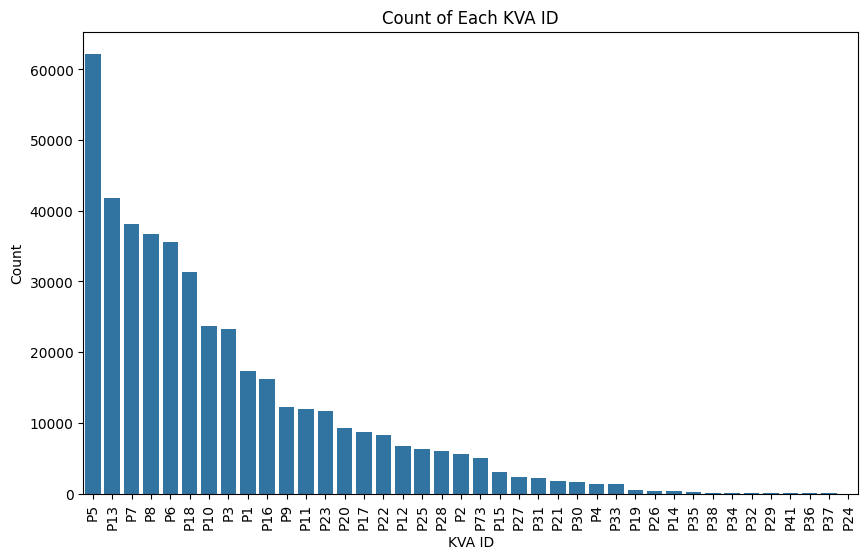

In [15]:
visualize.countplot_kva(df)

---

### 2. Book


In [16]:
print("There are", df["Book"].isnull().sum(), "nulls in the book column")
print("There are", len(df[df["Book"] == 0]), "0's in the book column")

There are 321376 nulls in the book column
There are 22 0's in the book column


In [17]:
df["Book"] = df["Book"].fillna(0)
len(df[df["Book"] == 0])

321398

This means that 321398 enquiries were never converted to bookings and further Sales


In [18]:
print(
    "Percentage of Enquiries converted to Bookings: ",
    ((sum(df["Book"]) / sum(df["Enquiry"])) * 100),
    "%",
)

Percentage of Enquiries converted to Bookings:  0.006271597808941096 %


---

### 3. Sales


In [19]:
print(
    "Percentage of Bookings converted to Sales: ",
    ((sum(df["SaleInvoice"]) / sum(df["Book"])) * 100),
    "%",
)

Percentage of Bookings converted to Sales:  54.20649531497085 %


---

### 4. OEM Name


In [20]:
print("Total OEMs in the dataset:", len(df[~df["OEMName"].isnull()]))

Total OEMs in the dataset: 18


In [21]:
df[~df["OEMName"].isnull()]

,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,OEMName,StateName,Region,DealerId,DealerName,KVA_Id
322362,1,1.0,0,2022-12-26 15:55:00,2022-12-26,NaT,MAHINDRA AND MAHINDRA LIMITED,Uttar Pradesh,North1,611.0,PRIME POWER GENERATORS PVT LTD. Chennai,P1
322363,1,1.0,0,2024-11-20 17:28:00,2024-12-11,NaT,Shyam Global Technoventures Pvt Ltd,Goa,West,587.0,POWERSAFE ENGINEERS,P7
322364,1,1.0,0,2024-12-11 16:45:00,2024-12-11,NaT,Perfect Generators Technologies Pvt. Ltd.,NaN,NaN,230.0,Perfect Generators Technologies Pvt. Ltd.,P11
322365,1,1.0,0,2024-12-07 17:27:00,2024-12-11,NaT,Tanwar Industries,Rajasthan,North1,380.0,Tanwar Industries,P18
322366,1,1.0,0,2024-12-10 16:58:00,2024-12-10,NaT,Southern Gensets,Kerala,South,449.0,Gentech Power Systems,P11
322367,1,1.0,0,2024-12-11 13:32:00,2024-12-11,NaT,Sharda Diesels Pvt Ltd,Bihar,East,351.0,Agro Power Equipment,P73
322368,1,1.0,0,2024-12-11 15:34:00,2024-12-11,NaT,Recon Technologies Pvt Ltd,Telangana,South,143.0,Recon Technologies Pvt. Ltd,P5
322369,1,1.0,0,2024-12-10 16:00:00,2024-12-10,NaT,Gangadhar Industries,Gujarat,West,46.0,Gangadhar Industries,P20
322370,1,1.0,0,2024-12-11 16:34:00,2024-12-11,NaT,GSP Power Projects retail Division,Orissa,East,454.0,Gurukurpa Generators,P5
322371,1,1.0,0,2024-12-11 18:26:00,2024-12-11,NaT,Escon Gensets Private Limited,Gujarat,West,521.0,Escon Gensets Private Limited,P5


⚡As there are only 18 rows contaning information about OEMs, we will be removing the column completely


In [22]:
df.drop(columns=["OEMName"], inplace=True)

---

### 5. State Name


In [23]:
df["StateName"].nunique()

36

In [24]:
df["StateName"].unique()

array([nan, 'Gujarat', 'Assam', 'Jammu & Kashmir', 'Goa',
       'Madhya Pradesh', 'Rajasthan', 'Uttar Pradesh', 'Telangana',
       'Kerala', 'Nagaland', 'Karnataka', 'Tamil Nadu', 'Maharashtra',
       'Andhra Pradesh', 'Bihar', 'Jharkhand', 'Manipur', 'Haryana',
       'Uttarakhand', 'Delhi', 'Chhattisgarh', 'Punjab', 'Meghalaya',
       'Arunachal Pradesh', 'West Bengal', 'Orissa', 'Puducherry',
       'Andaman & Nicobar Islands', 'Mizoram', 'Tripura', 'Chandigarh',
       'Daman & Diu', 'Dadra and Nagar Haveli', 'Sikkim',
       'Himachal Pradesh', 'Lakshadweep'], dtype=object)

🔬The above list contatins the names of states as well as union territories (except for Ladakh):<br>
UTs: Andaman and Nicobar Islands,
Chandigarh,
Dadra and Nagar Haveli and Daman and Diu,
Delhi,
Jammu and Kashmir,
Ladakh,
Lakshadweep,
Puducherry

---


In [25]:
len(df) - df["StateName"].isnull().sum()

np.int64(106088)

---

### 6. Region


In [26]:
df["Region"].unique()

array([nan, 'West', 'East', 'North1', 'South'], dtype=object)

In [27]:
len(df) - df["Region"].isnull().sum()

np.int64(106088)

---

### 7. Dealer Name & Dealer Id


In [28]:
df["DealerName"].nunique()

261

In [29]:
len(df) - df["DealerName"].isnull().sum()

np.int64(130501)

In [30]:
df["DealerId"].nunique()

261

In [31]:
df["DealerId"].isnull().sum()

np.int64(303172)

In [32]:
len(df[(df["DealerId"].isnull()) & (df["SaleInvoice"] == 0)])

303172

In [33]:
len(df[(df["DealerId"].isnull()) & (df["Book"] == 0)])

302982

🔬

- We can clearly observe that places where Dealer ID and Dealer Name are blank, the SaleInvoice Quantity is also 0. These might be enquiries that might have come online.
- We can also see that some of them have still gotten booked, but ultimately "Sale" matters.

---

⚡Since we have no information regarding the Dealers, we will be dropping these rows.


In [34]:
df = df[~df["DealerId"].isnull()]

In [35]:
df.shape

(130501, 11)

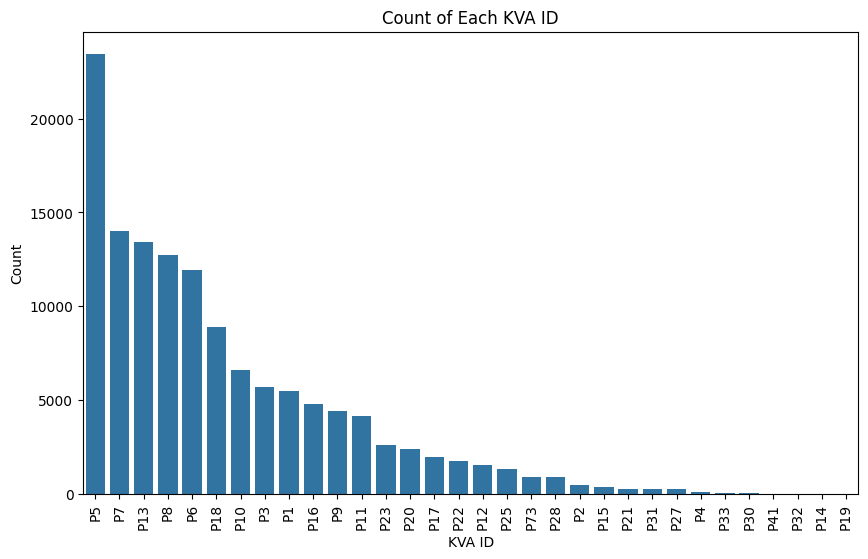

In [36]:
visualize.countplot_kva(df)

🔬We can see that demand for P5 is still higher though the overall count has decreased.

⚡Let's take P5 for our initial forecasting


# 📈 Analysis of P5


In [37]:
df_p5 = df[df["KVA_Id"] == "P5"]

In [38]:
df_p5.head()

,Enquiry,Book,SaleInvoice,enquiryDate,SalesOrderDate,InvoiceDate,StateName,Region,DealerId,DealerName,KVA_Id
303136,2,0.0,0,2020-06-25 00:00:00,NaT,NaT,NaN,NaN,230.0,Perfect Generators Technologies Pvt. Ltd.,P5
303154,2,0.0,0,2023-11-25 13:18:00,NaT,NaT,NaN,NaN,448.0,P L Bagri & Co,P5
303197,2,0.0,0,2024-03-20 19:29:00,NaT,NaT,NaN,NaN,568.0,Power Elite,P5
303232,2,0.0,0,2023-09-18 09:42:00,NaT,NaT,NaN,NaN,617.0,A J Industries,P5
303237,2,0.0,0,2024-12-05 00:00:00,NaT,NaT,NaN,NaN,660.0,Advik Enterprises,P5


In [39]:
df_p5.shape

(23461, 11)

In [40]:
df_p5 = df_p5.rename(
    columns={
        "Enquiry": "Enquiry_Quantity",
        "Book": "Booking_Quantity",
        "SaleInvoice": "Invoice_Quantity",
        "SalesOrderDate": "BookingDate",
    }
)

In [41]:
df_p5.head()

,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,enquiryDate,BookingDate,InvoiceDate,StateName,Region,DealerId,DealerName,KVA_Id
303136,2,0.0,0,2020-06-25 00:00:00,NaT,NaT,NaN,NaN,230.0,Perfect Generators Technologies Pvt. Ltd.,P5
303154,2,0.0,0,2023-11-25 13:18:00,NaT,NaT,NaN,NaN,448.0,P L Bagri & Co,P5
303197,2,0.0,0,2024-03-20 19:29:00,NaT,NaT,NaN,NaN,568.0,Power Elite,P5
303232,2,0.0,0,2023-09-18 09:42:00,NaT,NaT,NaN,NaN,617.0,A J Industries,P5
303237,2,0.0,0,2024-12-05 00:00:00,NaT,NaT,NaN,NaN,660.0,Advik Enterprises,P5


In [42]:
df_p5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23461 entries, 303136 to 433905
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Enquiry_Quantity  23461 non-null  int64         
 1   Booking_Quantity  23461 non-null  float64       
 2   Invoice_Quantity  23461 non-null  int64         
 3   enquiryDate       23461 non-null  datetime64[ns]
 4   BookingDate       20896 non-null  datetime64[ns]
 5   InvoiceDate       16289 non-null  datetime64[ns]
 6   StateName         19996 non-null  object        
 7   Region            19996 non-null  object        
 8   DealerId          23461 non-null  float64       
 9   DealerName        23461 non-null  object        
 10  KVA_Id            23461 non-null  object        
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 2.1+ MB


In [43]:
df_p5[df_p5["Booking_Quantity"] > 0].shape

(20892, 11)

In [44]:
df_p5.columns

Index(['Enquiry_Quantity', 'Booking_Quantity', 'Invoice_Quantity',
       'enquiryDate', 'BookingDate', 'InvoiceDate', 'StateName', 'Region',
       'DealerId', 'DealerName', 'KVA_Id'],
      dtype='object')

In [45]:
df_p5["EnquiryMonth"] = df_p5["enquiryDate"].dt.to_period("M")
df_p5["BookingMonth"] = df_p5["BookingDate"].dt.to_period("M")
df_p5["InvoiceMonth"] = df_p5["InvoiceDate"].dt.to_period("M")

In [46]:
df_p5.head()

,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,enquiryDate,BookingDate,InvoiceDate,StateName,Region,DealerId,DealerName,KVA_Id,EnquiryMonth,BookingMonth,InvoiceMonth
303136,2,0.0,0,2020-06-25 00:00:00,NaT,NaT,NaN,NaN,230.0,Perfect Generators Technologies Pvt. Ltd.,P5,2020-06,NaT,NaT
303154,2,0.0,0,2023-11-25 13:18:00,NaT,NaT,NaN,NaN,448.0,P L Bagri & Co,P5,2023-11,NaT,NaT
303197,2,0.0,0,2024-03-20 19:29:00,NaT,NaT,NaN,NaN,568.0,Power Elite,P5,2024-03,NaT,NaT
303232,2,0.0,0,2023-09-18 09:42:00,NaT,NaT,NaN,NaN,617.0,A J Industries,P5,2023-09,NaT,NaT
303237,2,0.0,0,2024-12-05 00:00:00,NaT,NaT,NaN,NaN,660.0,Advik Enterprises,P5,2024-12,NaT,NaT


In [48]:
# Storing P5 datframe in "data\interim"
df_p5.to_pickle(r"..\data\interim\P5_data.pkl")

#### Aggregating Quantities separately (Enquiry, Booking, Invoices)


In [49]:
df_f5 = pd.read_pickle(r"..\data\interim\P5_data.pkl")

In [50]:
agg_enquiry = (
    df_p5.groupby(["KVA_Id", "StateName", "Region", "EnquiryMonth"])["Enquiry_Quantity"]
    .sum()
    .reset_index()
)
agg_booking = (
    df_p5.groupby(["KVA_Id", "StateName", "Region", "BookingMonth"])["Booking_Quantity"]
    .sum()
    .reset_index()
)
agg_invoice = (
    df_p5.groupby(["KVA_Id", "StateName", "Region", "InvoiceMonth"])["Invoice_Quantity"]
    .sum()
    .reset_index()
)

#### Generating plots by State for P5 (path: "reports\figures")


In [51]:
for statename in df_p5["StateName"].unique():
    if pd.notna(statename):
        print("Processing: ", statename)
        visualize.plot_by_state(statename, agg_enquiry, agg_booking, agg_invoice)

print("Finished Processing")
print("__________________________________________________")

Processing:  Assam
Processing:  Telangana
Processing:  Gujarat
Processing:  Nagaland
Processing:  Rajasthan
Processing:  Bihar
Processing:  Maharashtra
Processing:  Jharkhand
Processing:  Uttar Pradesh
Processing:  Meghalaya
Processing:  Arunachal Pradesh
Processing:  Andhra Pradesh
Processing:  Karnataka
Processing:  Tamil Nadu
Processing:  Uttarakhand
Processing:  Goa
Processing:  Madhya Pradesh
Processing:  Haryana
Processing:  Mizoram
Processing:  Jammu & Kashmir
Processing:  Punjab
Processing:  Kerala
Processing:  Orissa
Processing:  Andaman & Nicobar Islands
Processing:  Puducherry
Processing:  Tripura
Processing:  Sikkim
Processing:  Manipur
Processing:  West Bengal
Processing:  Himachal Pradesh
Processing:  Delhi
Processing:  Chandigarh
Processing:  Chhattisgarh
Processing:  Daman & Diu


#### Creating a combined_df by combining agg_enquiry, agg_booking, agg_invoice


In [84]:
combined_df = pd.DataFrame()
combined_df = pd.merge(
    agg_enquiry,
    agg_booking,
    left_on=["KVA_Id", "StateName", "Region", "EnquiryMonth"],
    right_on=["KVA_Id", "StateName", "Region", "BookingMonth"],
    how="outer",
)
combined_df = pd.merge(
    combined_df,
    agg_invoice,
    left_on=["KVA_Id", "StateName", "Region", "EnquiryMonth"],
    right_on=["KVA_Id", "StateName", "Region", "InvoiceMonth"],
    how="outer",
)

In [85]:
# Fill missing values in numeric columns with 0 but not for YearMonth
combined_df.fillna(
    {
        "Enquiry_Quantity": 0,
        "Booking_Quantity": 0,
        "Invoice_Quantity": 0,
    },
    inplace=True,
)

# Check initial data types and missing values in the month columns
print("Initial Data Types:")
print(combined_df[["EnquiryMonth", "BookingMonth", "InvoiceMonth"]].dtypes)

print("\nInitial Missing Values in Each Column:")
print(combined_df[["EnquiryMonth", "BookingMonth", "InvoiceMonth"]].isnull().sum())

# Step 1: Populate YearMonth based on the available period[M] columns in priority order
# Copy EnquiryMonth to YearMonth, filling missing values with BookingMonth first
combined_df["YearMonth"] = combined_df["EnquiryMonth"].copy()

# Fill missing YearMonth with BookingMonth
combined_df["YearMonth"] = combined_df["YearMonth"].fillna(combined_df["BookingMonth"])

# Fill any remaining missing YearMonth with InvoiceMonth
combined_df["YearMonth"] = combined_df["YearMonth"].fillna(combined_df["InvoiceMonth"])

# Check how many missing values remain after filling
print("\nMissing Values in YearMonth after filling with BookingMonth and InvoiceMonth:")
print(combined_df["YearMonth"].isnull().sum())

# Ensure YearMonth is still in period[M] format
print("\nCheck YearMonth column types:")
print(combined_df["YearMonth"].apply(type).unique())

# Final check for data types and nulls
print("\nFinal Data Types:")
print(combined_df.dtypes)

print("\nSample of the final dataframe:")
print(combined_df.head())

# Check the YearMonth column types after conversion
print("\nCheck YearMonth column types:")
print(combined_df["YearMonth"].apply(type).unique())

combined_df.drop(columns=["EnquiryMonth", "BookingMonth", "InvoiceMonth"], inplace=True)

Initial Data Types:
EnquiryMonth    period[M]
BookingMonth    period[M]
InvoiceMonth    period[M]
dtype: object

Initial Missing Values in Each Column:
EnquiryMonth     85
BookingMonth    134
InvoiceMonth    230
dtype: int64

Missing Values in YearMonth after filling with BookingMonth and InvoiceMonth:
0

Check YearMonth column types:
[<class 'pandas._libs.tslibs.period.Period'>]

Final Data Types:
KVA_Id                 object
StateName              object
Region                 object
EnquiryMonth        period[M]
Enquiry_Quantity      float64
BookingMonth        period[M]
Booking_Quantity      float64
InvoiceMonth        period[M]
Invoice_Quantity      float64
YearMonth           period[M]
dtype: object

Sample of the final dataframe:
  KVA_Id                  StateName Region EnquiryMonth  Enquiry_Quantity  \
0     P5  Andaman & Nicobar Islands  South      2023-03               2.0   
1     P5  Andaman & Nicobar Islands  South      2023-06               1.0   
2     P5  Andaman & N

In [86]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   KVA_Id            1900 non-null   object   
 1   StateName         1900 non-null   object   
 2   Region            1900 non-null   object   
 3   Enquiry_Quantity  1900 non-null   float64  
 4   Booking_Quantity  1900 non-null   float64  
 5   Invoice_Quantity  1900 non-null   float64  
 6   YearMonth         1900 non-null   period[M]
dtypes: float64(3), object(3), period[M](1)
memory usage: 104.0+ KB


In [87]:
combined_df.head(20)

,KVA_Id,StateName,Region,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,YearMonth
0,P5,Andaman & Nicobar Islands,South,2.0,2.0,2.0,2023-03
1,P5,Andaman & Nicobar Islands,South,1.0,1.0,1.0,2023-06
2,P5,Andaman & Nicobar Islands,South,1.0,1.0,0.0,2023-08
3,P5,Andaman & Nicobar Islands,South,2.0,2.0,0.0,2023-11
4,P5,Andaman & Nicobar Islands,South,2.0,2.0,0.0,2023-12
5,P5,Andaman & Nicobar Islands,South,1.0,0.0,0.0,2024-02
6,P5,Andaman & Nicobar Islands,South,2.0,2.0,0.0,2024-03
7,P5,Andaman & Nicobar Islands,South,2.0,3.0,0.0,2024-04
8,P5,Andaman & Nicobar Islands,South,1.0,1.0,0.0,2024-10
9,P5,Andaman & Nicobar Islands,South,1.0,1.0,0.0,2024-12


In [88]:
combined_df.isnull().sum()

KVA_Id              0
StateName           0
Region              0
Enquiry_Quantity    0
Booking_Quantity    0
Invoice_Quantity    0
YearMonth           0
dtype: int64

In [89]:
combined_df.to_pickle(r"..\data\interim\combined_data.pkl")

# Feature Engineering


### 0. Reading the Combined_Data


In [285]:
combined_df = pd.read_pickle(r"..\data\interim\combined_data.pkl")

#### Preprocessing


In [286]:
combined_df = combined_df.drop(columns=["Region"])
combined_df.sort_values(by=["KVA_Id", "StateName", "YearMonth"], inplace=True)

In [287]:
combined_df.head(20)

,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,YearMonth
0,P5,Andaman & Nicobar Islands,2.0,2.0,2.0,2023-03
1,P5,Andaman & Nicobar Islands,1.0,1.0,1.0,2023-06
2,P5,Andaman & Nicobar Islands,1.0,1.0,0.0,2023-08
3,P5,Andaman & Nicobar Islands,2.0,2.0,0.0,2023-11
4,P5,Andaman & Nicobar Islands,2.0,2.0,0.0,2023-12
5,P5,Andaman & Nicobar Islands,1.0,0.0,0.0,2024-02
6,P5,Andaman & Nicobar Islands,2.0,2.0,0.0,2024-03
7,P5,Andaman & Nicobar Islands,2.0,3.0,0.0,2024-04
8,P5,Andaman & Nicobar Islands,1.0,1.0,0.0,2024-10
9,P5,Andaman & Nicobar Islands,1.0,1.0,0.0,2024-12


#### Defining parameters and methods


In [288]:
def fill_missing_months(df):
    # Ensure that 'YearMonth' is a Timestamp
    if df["YearMonth"].dtype.name == "period[M]":
        df["YearMonth"] = df["YearMonth"].dt.to_timestamp()

    # Get the minimum and maximum dates per group
    min_date = df["YearMonth"].min()
    max_date = df["YearMonth"].max()

    all_dates = pd.date_range(min_date, max_date, freq="ME").to_period("M")

    # Step 2: Create a DataFrame for the continuous YearMonth
    all_dates_df = pd.DataFrame(all_dates, columns=["YearMonth"])

    if df["YearMonth"].dtype.name == "datetime64[ns]":
        # Convert back to Period[M] if it's a timestamp
        df["YearMonth"] = df["YearMonth"].dt.to_period("M")

    # Step 3: Merge with the original data
    df_merged = pd.merge(all_dates_df, df, on="YearMonth", how="left")

    # Step 4: Forward fill KVA_Id and StateName for the newly created rows
    df_merged["KVA_Id"] = df_merged["KVA_Id"].ffill()
    df_merged["StateName"] = df_merged["StateName"].ffill()

    # Step 5: Fill NaN values in other columns with 0 (e.g., for Sales)
    df_merged.fillna(0, inplace=True)

    return df_merged

    # return df

In [289]:
grouped = combined_df.groupby(["KVA_Id", "StateName"])

results = []
for name, group in grouped:
    filled_group = fill_missing_months(group)
    # Add back the group columns
    filled_group["KVA_Id"] = name[0]
    filled_group["StateName"] = name[1]
    results.append(filled_group)

# Concatenate the results into the final DataFrame
combined_df_filled = pd.concat(results).reset_index(drop=True)

In [293]:
combined_df_filled.head()

,YearMonth,KVA_Id,StateName,Enquiry_Quantity,Booking_Quantity,Invoice_Quantity,Enquiry_Quantity_lag1,Enquiry_Quantity_lag2,Enquiry_Quantity_lag3,Booking_Quantity_lag1,Booking_Quantity_lag2,Booking_Quantity_lag3,Invoice_Quantity_lag1,Invoice_Quantity_lag2,Invoice_Quantity_lag3
0,2023-03,P5,Andaman & Nicobar Islands,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04,P5,Andaman & Nicobar Islands,0.0,0.0,0.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN
2,2023-05,P5,Andaman & Nicobar Islands,0.0,0.0,0.0,0.0,2.0,NaN,0.0,2.0,NaN,0.0,2.0,NaN
3,2023-06,P5,Andaman & Nicobar Islands,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0
4,2023-07,P5,Andaman & Nicobar Islands,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [291]:
rolling_window = 3
lags = [1, 2, 3]

### 1. Lag Features


In [292]:
# Create lag features for Enquiry_Quantity, Booking_Quantity, and Invoice_Quantity
for col in ["Enquiry_Quantity", "Booking_Quantity", "Invoice_Quantity"]:
    for lag in lags:
        combined_df_filled[f"{col}_lag{lag}"] = combined_df_filled.groupby(
            ["KVA_Id", "StateName"]
        )[col].shift(lag)

### 2. Rolling Statistics


In [ ]:
for col in ["Enquiry_Quantity", "Booking_Quantity", "Invoice_Quantity"]:
    combined_df_filled[f"{col}_rolling_mean"] = (
        combined_df_filled.groupby(["KVA_Id", "StateName"])[col]
        .rolling(rolling_window, min_periods=1)
        .mean()
        .reset_index(drop=True)
    )
    combined_df_filled[f"{col}_rolling_median"] = (
        combined_df_filled.groupby(["KVA_Id", "StateName"])[col]
        .rolling(rolling_window, min_periods=1)
        .median()
        .reset_index(drop=True)
    )
    combined_df_filled[f"{col}_rolling_std"] = (
        combined_df_filled.groupby(["KVA_Id", "StateName"])[col]
        .rolling(rolling_window, min_periods=1)
        .std()
        .reset_index(drop=True)
    )